# Importing Libraries and Images

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf

In [2]:
os.listdir("../input/garbage-classification/garbage_classification")

['metal',
 'white-glass',
 'biological',
 'paper',
 'brown-glass',
 'battery',
 'trash',
 'cardboard',
 'shoes',
 'clothes',
 'plastic',
 'green-glass']

## Creating a DataFrame

In [3]:
data = pd.DataFrame()
path="../input/garbage-classification/garbage_classification/"
for category in os.listdir(path):
    temp = pd.DataFrame()
    temp['path'] = np.nan
    temp['target'] = category
    i = 0
    for photo in os.listdir(path+category):
        temp.loc[i, 'path'] = path+category+ "/" + photo
        temp.loc[i, 'filename'] = category+ "/" + photo
        temp.loc[i, 'target'] = category
        i += 1
    data = pd.concat([data, temp], ignore_index=True)
    del temp

In [4]:
data

,path,target,filename
0,../input/garbage-classification/garbage_classi...,metal,metal/metal375.jpg
1,../input/garbage-classification/garbage_classi...,metal,metal/metal561.jpg
2,../input/garbage-classification/garbage_classi...,metal,metal/metal341.jpg
3,../input/garbage-classification/garbage_classi...,metal,metal/metal688.jpg
4,../input/garbage-classification/garbage_classi...,metal,metal/metal374.jpg
...,...,...,...
15510,../input/garbage-classification/garbage_classi...,green-glass,green-glass/green-glass127.jpg
15511,../input/garbage-classification/garbage_classi...,green-glass,green-glass/green-glass607.jpg
15512,../input/garbage-classification/garbage_classi...,green-glass,green-glass/green-glass508.jpg
15513,../input/garbage-classification/garbage_classi...,green-glass,green-glass/green-glass61.jpg


### Displaying random images

../input/garbage-classification/garbage_classification/cardboard/cardboard298.jpg


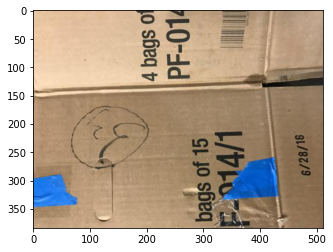

../input/garbage-classification/garbage_classification/paper/paper239.jpg


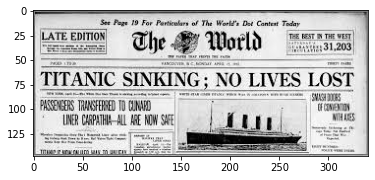

../input/garbage-classification/garbage_classification/brown-glass/brown-glass163.jpg


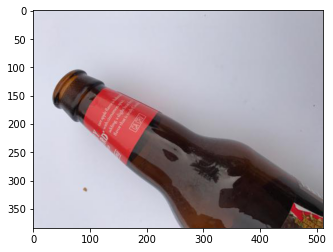

../input/garbage-classification/garbage_classification/trash/trash509.jpg


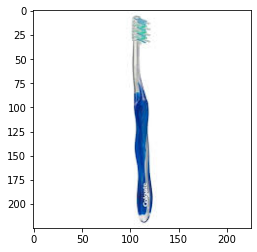

../input/garbage-classification/garbage_classification/paper/paper404.jpg


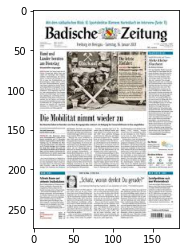

../input/garbage-classification/garbage_classification/shoes/shoes964.jpg


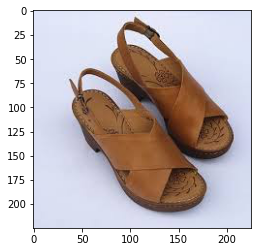

../input/garbage-classification/garbage_classification/biological/biological130.jpg


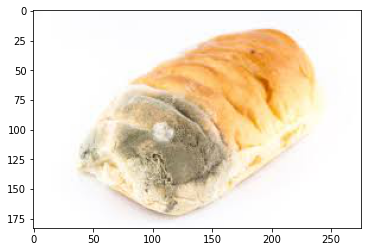

../input/garbage-classification/garbage_classification/clothes/clothes3429.jpg


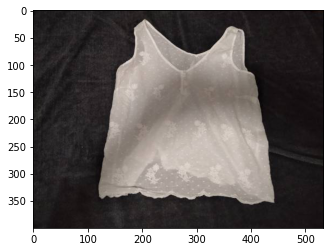

../input/garbage-classification/garbage_classification/white-glass/white-glass580.jpg


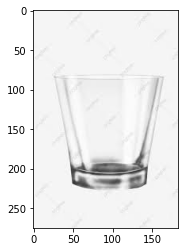

../input/garbage-classification/garbage_classification/shoes/shoes20.jpg


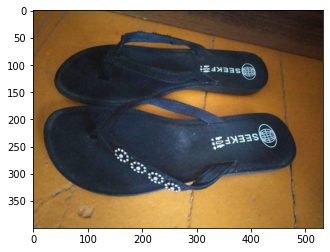

In [5]:
import random
import matplotlib.image as mpimg

for i in range (10):
    random_row = random.randint(0, len(data)-1)
    sample = data.iloc[random_row]
    image = mpimg.imread(sample['path'])
    plt.imshow(image)
    print(sample['path'])
    plt.show()

### Preprocessing the dataset

In [6]:
total_counts = 0

for category in os.listdir(path):
    count_class = 0
    for photo in os.listdir(path + category):
        count_class += 1
        total_counts += 1
    print(str(category) + " has " + str(count_class) + " photos")

metal has 769 photos
white-glass has 775 photos
biological has 985 photos
paper has 1050 photos
brown-glass has 607 photos
battery has 945 photos
trash has 697 photos
cardboard has 891 photos
shoes has 1977 photos
clothes has 5325 photos
plastic has 865 photos
green-glass has 629 photos


The dataset is **imbalanced**. We will remove some random images from 'clothes' and 'shoes' to improve the distribution.

In [7]:
clothesDrop=data[data['target']=='clothes'].sample(n=4525)
shoesDrop=data[data['target']=='shoes'].sample(n=1000)

In [8]:
data.drop(labels=clothesDrop.index.values, inplace=True)
data.drop(labels=shoesDrop.index.values, inplace=True)
data['target'].value_counts()

paper          1050
biological      985
shoes           977
battery         945
cardboard       891
plastic         865
clothes         800
white-glass     775
metal           769
trash           697
green-glass     629
brown-glass     607
Name: target, dtype: int64

# Model

In [9]:
# Shape of EfficientNetB0
im_shape = (224, 224)
batch_size = 64
seed = 42

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

Splitting the dataset into training, testing and validation.

In [11]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

len(train_df), len(val_df), len(test_df)

(7992, 999, 999)

Using ImageDataGenerator on training, testing and validation dataset.

In [12]:
train_generator = data_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=path,
    x_col='filename',
    y_col='target',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

Found 7992 validated image filenames belonging to 12 classes.


In [13]:
val_generator = data_generator.flow_from_dataframe(
    dataframe=val_df,
    directory=path,
    x_col='filename',
    y_col='target',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

Found 999 validated image filenames belonging to 12 classes.


In [14]:
test_generator = data_generator.flow_from_dataframe(
    dataframe=test_df,
    directory=path,
    x_col='filename',
    y_col='target',
    target_size=im_shape,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=seed)

Found 999 validated image filenames belonging to 12 classes.


In [15]:
nb_train_samples = train_generator.samples
nb_validation_samples = val_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


### Model

In [16]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense


base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(im_shape[0], im_shape[1], 3))

x = base_model.output
x = Flatten()(x)
'''
Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. 
We flatten the output of the convolutional layers to create a single long feature vector. 
And it is connected to the final classification model, which is called a fully-connected layer.
'''
x = Dense(100, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable=False

# model.summary()

optimizer = Adam()
'''
Optimizers are Classes or methods used to change the attributes of the model such as weights and learning rate 
in order to reduce the losses. Optimizers help to get results faster.
'''
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

16719872/16705208 [==============================] - 1s 0us/step


In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

epochs = 30


callbacks_list = [
    ModelCheckpoint(filepath='model_EfficientnetB0.h5',monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=val_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/30
124/124 [==============================] - 65s 434ms/step - loss: 0.4370 - accuracy: 0.8620 - val_loss: 0.3046 - val_accuracy: 0.9000

Epoch 00001: val_loss improved from inf to 0.30457, saving model to model_EfficientnetB0.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
124/124 [==============================] - 32s 254ms/step - loss: 0.0653 - accuracy: 0.9810 - val_loss: 0.3325 - val_accuracy: 0.8958

Epoch 00002: val_loss did not improve from 0.30457
Epoch 3/30
124/124 [==============================] - 32s 256ms/step - loss: 0.0388 - accuracy: 0.9884 - val_loss: 0.3003 - val_accuracy: 0.9177

Epoch 00003: val_loss improved from 0.30457 to 0.30028, saving model to model_EfficientnetB0.h5
Epoch 4/30
124/124 [==============================] - 32s 256ms/step - loss: 0.0191 - accuracy: 0.9937 - val_loss: 0.3503 - val_accuracy: 0.9115

Epoch 00004: val_loss did not improve from 0.30028
Epoch 5/30
124/124 [==============================] - 32s 256ms/step - loss: 0.0281 - accuracy: 0.9915 - val_loss: 0.3664 - val_accuracy: 0.9198

Epoch 00005: val_loss did not improve from 0.30028
Epoch 6/30
124/124 [==============================] - 35s 286ms/step - loss: 0.0334 - accuracy: 0.9919 - val_loss: 0.4437 - val_accuracy: 0.9062

Epoch 00006: val_loss

# Prediction and Accuracy

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
cm

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

     battery       0.98      0.93      0.95        96
  biological       0.97      0.99      0.98       104
 brown-glass       0.72      0.94      0.82        53
   cardboard       0.95      0.94      0.95        84
     clothes       0.97      1.00      0.99        74
 green-glass       0.96      0.90      0.93        61
       metal       0.96      0.82      0.88        78
       paper       0.96      0.94      0.95       105
     plastic       0.74      0.91      0.82        88
       shoes       0.98      0.95      0.97       103
       trash       0.99      0.92      0.95        72
 white-glass       0.90      0.80      0.85        81

    accuracy                           0.92       999
   macro avg       0.92      0.92      0.92       999
weighted avg       0.93      0.92      0.92       999



In [19]:
cm

array([[ 89,   0,   6,   1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 103,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1,  50,   0,   0,   0,   0,   0,   2,   0,   0,   0],
       [  0,   0,   0,  79,   0,   0,   0,   3,   2,   0,   0,   0],
       [  0,   0,   0,   0,  74,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   4,   0,   0,  55,   1,   0,   1,   0,   0,   0],
       [  1,   0,   3,   0,   0,   0,  64,   1,   7,   0,   0,   2],
       [  1,   0,   0,   1,   0,   0,   0,  99,   3,   0,   0,   1],
       [  0,   2,   0,   0,   0,   1,   1,   0,  80,   1,   0,   3],
       [  0,   0,   2,   0,   2,   0,   0,   0,   0,  98,   1,   0],
       [  0,   0,   1,   1,   0,   0,   0,   0,   2,   1,  66,   1],
       [  0,   0,   2,   1,   0,   1,   1,   0,  11,   0,   0,  65]])

In [20]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saved model to disk
